# 1. 物体検出とは
本章では物体検出タスクに取り組みながら，**SSD(Single Shot MultiBox Detector)**と呼ばれるディープラーニングについて学習する。**SSD**はディープラーニングの応用手法として複雑な部類のものであるため、理解に時間がかかるかもしれない。

特に本章は実装コードが難しく、本書の中でも最も大変な章である。
まずは、物体検出とSSDが何をやっているのか処理内容を概念レベルで理解することを目指すと良い。

本節の達成目標
1. 物体検出とは、何をインプットに何をアウトレットするタスクなのかを理解する
2. VOCデータセットについて理解する
3. SSDによる物体検出の６Stepの流れを理解する

## 物体検出の概要
**物体検出**：画像に含まれている複数の物体に対して、物体の領域と物体名を特定するタスク


---



物体検出を施した画像には物体を囲う枠が表示される(例えば乗馬の画像では人personと馬horseが囲われている)。この枠を「**バウンディングボックス(Bounding Box**)」と呼ぶ。枠の左上にはラベル名が表示されていて、person:1.00, horse:1.00のように表示されている。ラベル名は検出した物体のクラスを表していて、ラベル名後半の数字は**確信度(confidence)**を表す。

## 物体検出タスクのインプットとアウトプット
物体検出のインプットは画像であり、アウトプットは以下の3つ
1. 画像のどこに物体が存在するのかを示すバウンディングボックスの位置と大きさ情報
2. 各バウンディングボックスが何の物体であるのかを表すラベル情報
3. その検出に対する確信度=confidence

バウンディングボックスは長方形の左端$x_{min}$, 上端$y_{max}$, 右端$x_{max}$, 下端$y_{min}$を指定する。
SSDのアルゴリズムの途中ではバウンディングボックスの形を、中心の$x$座標を$cx$、中心の$y$座標を$cy$、バウンディングボックスの幅$w$、バウンディングボックスの高さ$h$で指定することもある。

ラベル情報は今回検出したいクラス数$O$に、どの物体でもない背景クラス(background)を足した($O+1$)種類のクラスから、各バウンディングボックスにつき1つのラベルを求めます。

検出の確信度(confidence)は各バウンディングボックスとラベルに対する確からしさを示す。物体検出ではconfidenceの高いバウンディングボックスのみを最終的にアウトプットする。

## VOCデータセットとは
VOCデータセットは物体検出のコンテストで使用されたデータセットである。

VOCデータセットのうち、2007のデータと2012年のデータが主に使用される。本章ではVOC2012データセットを使用する。
- クラス数は20種類
- 訓練データ5,717枚
- 検証データ5,823枚

20種類のクラスはaeroplane, bicycle, bird, boatなど。ここに背景クラスを足して全部で21種類のクラスを使用する。

データセットの各画像にはバウンディングボックスの正解情報として、長方形の左端$x_{min}$, 上端$y_{max}$, 右端$x_{max}$, 下端$y_{min}$と、物体のクラスを示すラベルのアノテーションデータが付与されている。アノテーションデータは画像ごとにxml形式で保存されている。

## SSDによる物体検出の流れ
- SSD300 $300\times 300$ピクセルにリサイズして処理する
- SSD512 $512\times 512$ピクセルで処理する

SSDでは「**デフォルトボックス**」という定型的な長方形をあらかじめ用意しておき、この長方形のデフォルトボックスをどのように変形すればバウンディングボックスに一致するか問う情報を出力する。

デフォルトボックスの情報が$(cx_d, cy_d, w_d, h_d)$であった場合、オフセットの情報は$(\Delta cx, \Delta cy, \Delta w, \Delta h)$の4変数となり、SSDにおいてバウンディングボックスの情報は次のようになる。

\begin{align*}
cx &= cx_d + 0.1\Delta cx \times \Delta w_d \\
cy &= cy_d + 0.1\Delta cy \times \Delta h_d \\
w &= w_d \times {\rm exp}(0.2\Delta w) \\
h &= h_d \times {\rm exp}(0.2\Delta h)
\end{align*}

これはSSDの学習規則の定義であり、理論的に導かれるものではない。


*物体検出のための処理の流れ*
- Step1 <br>
画像の前処理として、$300\times 300$ピクセルの大きさにリサイズする。(色の標準化)
- Step2 <br>
画像に対して様々な大きさとアスペクト比のデフォルトボックスを用意する。SSD300の場合、8,732個のデフォルトボックスを用意する。各デフォルトボックスは入力画像とは関係なく、どの画像に対してもまったく同じものを用意する。
- Step3 <br>
前処理した画像をSSDのネットワークに入力し、8,732個のデフォルトボックスそれぞれに対して、デフォルトボックスをバウンディングボックスへと修正するオフセット情報4変数とデフォルトボックスが各クラスの物体である確信度を21個(クラス数分)の合計$8,732\times(4+21)=218,300$個の情報を出力させる。
- Step4 <br>
8,732個のデフォルトボックスのうち、確信度が高いものを上位から$top_k$個(SSD300では200個)を取り出す。ここでデフォルトボックスに対応するラベルは21個のクラスで最も確信度が高いクラスのラベルになっている。
- Step5 <br>
オフセット情報を使用し、デフォルトボックスをバウンディングボックスへ変換する。Step4で取り出したtop_k個のデフォルトボックスのうち、バウンディングボックスの重なりが大きいもの(同じ物体を検出していると思われるもの)が複数ある場合は、最も確信度が高いバウンディングボックスだけを残す。
- Step6 <br>
最終的なバウンディングボックスとそのラベルを出力する。Step6では確信度のしきい値を決め、しきい値以上の確信度をもつバウンディングボックスのみを最終出力とする。誤検出を避けたい場合は、高いしきい値を、未検出を防ぎたい場合は低いしきい値を設定する。

# 2. Datasetの実装
本節で実装するDatasetクラスはSSDに特有なものではなく、その他の物体検出アルゴリズムでも使用できる。

達成目標
1. 物体検出で使用するDatasetクラスを作成できるようになる
2. SSDの学習時のDataAugmentationで何をしているのかを理解する


In [1]:
# ライブラリインポート
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import itertools
import pandas as pd
from math import sqrt

path = '/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/'

## 画像データ、アノテーションデータへのファイルパスのリストを作成
物体検出のDatasetクラスと画像分類のDatasetクラスの大きな違いは、アノテーションデータの存在である。
- 画像分類ではファイル名やフォルダ目にクラス名が含まれていて、答えとなるデータ(アノテーションデータ)は存在しなかった。
- 物体検出では物体位置とラベルの答えとなるアノテーションはバウンディングボックスの情報であり、アノテーションデータとして提供されている。物体検出ではアノテーションデータと画像を対応させる必要がある。

物体検出では前処理で画像をリサイズするときにアノテーションデータ(バウンディングボックス情報)も同時に変更する必要がある。


本章で扱うVOC2012のデータセットでは訓練用と検証用のデータがすべて「JPEGImages」に格納されている。同様にアノテーションデータにつていもフォルダ「Annotations」に格納されている。「ImagesSets/Main」にある「train.txt」、「val.txt」に訓練用と検証用のファイルを示すファイル名のidがそれぞれ格納されている。

train.txtとval.txtを読み込んでファイル名のidを取得して、画像とアノテーションのパスを作成する。

In [ ]:
os.path.join(path, 'data', 'ImageSets/Main/train.txt')

'/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/ImageSets/Main/train.txt'

In [ ]:
open(os.path.join('/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012', 'ImageSets/Main/train.txt'))


<_io.TextIOWrapper name='/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012/ImageSets/Main/train.txt' mode='r' encoding='UTF-8'>

In [ ]:
def make_datapath_list(rootpath):
  '''
  データへのパスを格納したリストを作成

  Parameters
  --------------------
  rootpath: str
    データフォルダへのパス
  
  Returns
  --------------------
  ret: train_img_list, train_anno_list, val_img_list, val_anno_list
    データへのパスを格納したリスト
  '''
  # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成d
  imgpath_template = os.path.join(rootpath, 'JPEGImages', '%s.jpg')
  annopath_template = os.path.join(rootpath, 'Annotations', '%s.xml')

  # 訓練と検証、それぞれのファイルIDを取得する
  train_id_names = os.path.join(rootpath, 'ImageSets/Main/train.txt')
  val_id_names = os.path.join(rootpath, 'ImageSets/Main/val.txt')

  train_img_list = []
  train_anno_list = []

  for line in open(train_id_names):
    file_id = line.strip()
    img_path = (imgpath_template % file_id)
    anno_path = (annopath_template % file_id)
    train_img_list.append(img_path)
    train_anno_list.append(anno_path)

  val_img_list = []
  val_anno_list = []
  
  for line in open(val_id_names):
    file_id = line.strip()
    img_path = (imgpath_template % file_id)
    anno_path = (annopath_template % file_id)
    val_img_list.append(img_path)
    val_anno_list.append(anno_path)

  return train_img_list, train_anno_list, val_img_list, val_anno_list 

In [ ]:
# 動作確認
rootpath = '/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
print(train_img_list[0])
print(train_anno_list[0])

/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012/Annotations/2008_000008.xml


## xml形式のアノテーションデータをリストに変換
xmlからPythonのリスト型変数に変換するクラス`Anno_xml2list`を作成

メソッド`__call__`では引数に対象画像の幅と高さを指定する。これはバウンディングボックスの座標を規格化するために使用する。

アノテーションデータは物体の名前が物体クラス名の文字列で格納されている。
コンストラクタの引数にVOCデータセットのクラス名20個を配置したリストclassesを与え、

`label_idx = self.classes.index(name)`

によってクラス名をインデックスへ変換する

In [ ]:
!pip install opencv-python

In [ ]:
!cat /content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/data/VOCdevkit/VOC2012/Annotations/2008_000008.xml

<annotation>
	<folder>VOC2012</folder>
	<filename>2008_000008.jpg</filename>
	<source>
		<database>The VOC2008 Database</database>
		<annotation>PASCAL VOC2008</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>442</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>horse</name>
		<pose>Left</pose>
		<truncated>0</truncated>
		<occluded>1</occluded>
		<bndbox>
			<xmin>53</xmin>
			<ymin>87</ymin>
			<xmax>471</xmax>
			<ymax>420</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
	<object>
		<name>person</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<occluded>0</occluded>
		<bndbox>
			<xmin>158</xmin>
			<ymin>44</ymin>
			<xmax>289</xmax>
			<ymax>167</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
</annotation>


In [ ]:
import xml.etree.ElementTree as ET
xml = ET.parse(train_anno_list[0]).getroot()
obj = next(xml.iter('object'))
obj.find('difficult').text

'0'

In [ ]:
obj.find('name').text

'horse'

In [ ]:
import xml.etree.ElementTree as ET
classes = []
cnt = 0
for anno_path in train_anno_list:
  if cnt == 20:
      break
  xml = ET.parse(anno_path).getroot()
  for obj in xml.iter('object'):
    name = obj.find('name').text
    print(name)
    if name  not in classes:
      cnt += 1
      classes.append(name)
      if cnt == 20:
        break

horse
person
bottle
bottle
dog
dog
dog
tvmonitor
bottle
person
person
person
car
car
aeroplane
bicycle
bicycle
person
boat
boat
aeroplane
person
person
person
person
person
person
chair
chair
chair
diningtable
pottedplant
person
train
dog
cat
dog
tvmonitor
chair
chair
car
car
chair
tvmonitor
chair
chair
sofa
sofa
bird
person
cat
bird
dog
sheep
bird
car
motorbike
car
person
cat
bottle
sofa
person
person
bird
person
person
bus
horse
person
horse
person
person
car
car
car
motorbike
person
motorbike
person
boat
aeroplane
bottle
dog
car
person
cat
person
car
car
pottedplant
person
car
boat
person
person
bicycle
bird
car
person
bicycle
pottedplant
bottle
bottle
bicycle
cat
aeroplane
person
car
person
person
person
person
tvmonitor
bottle
chair
person
person
person
person
person
person
person
car
cat
chair
diningtable
person
boat
person
pottedplant
motorbike
car
person
person
bus
person
person
person
car
bus
person
person
person
person
person
car
car
car
car
boat
person
person
person
person
p

In [ ]:
classes

['horse',
 'person',
 'bottle',
 'dog',
 'tvmonitor',
 'car',
 'aeroplane',
 'bicycle',
 'boat',
 'chair',
 'diningtable',
 'pottedplant',
 'train',
 'cat',
 'sofa',
 'bird',
 'sheep',
 'motorbike',
 'bus',
 'cow']

In [ ]:
import xml.etree.ElementTree as ET

class Anno_xml2list(object):
  '''
  1枚の画像に対する「xml形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。
  
  Attributes
  ------------------
  classes: リスト
    VOCのクラス名を格納したリスト

  '''

  def __init__(self, classes):
    self.classes = classes

  def __call__(self, xml_path, width, height):
    '''
    1枚の画像に対する「xml形式のアノテーションデータ」を画像サイズで規格化してリスト形式に変換する

    Parameters
    --------------------
    xml_path: str
      xmlファイルへのパス
    width: int
      対象画像の幅
    height: int
      対象画像の高さ

    Returns
    ----------------------
    ret: [[xmin, ymin, xmax, ymax, label_ind], ...]
      物体のアノテーションデータを格納したリスト。画像内に存在する物体数分だけ要素を持つ
    '''

    # 画像内のすべての物体のアノテーションリスト
    ret = []

    # xmlファイルを読み込む
    xml = ET.parse(xml_path).getroot()

    # 画像内になる物体数だけループする
    for obj in xml.iter('object'):

      # アノテーションで検知がdifficultと設定されているものを除外
      difficult = int(obj.find('difficult').text)
      if difficult == 1:
        continue

      # 1つの物体に対するアノテーションを格納するリスト
      bndbox = []

      name = obj.find('name').text.lower().strip() # 物体名
      bbox = obj.find('bndbox') # バウンディングボックスの情報

      # アノテーションのxmin, ymin, xmax, ymaxを取得し、0~1に規格化
      pts = ['xmin', 'ymin', 'xmax', 'ymax']

      for pt in pts:
        # VOCは原点が(1,1)なので(0,0)に移す
        cur_pixel = int(bbox.find(pt).text) - 1

        # 幅、高さで規格化
        if pt == 'xmin' or pt == 'xmax': # x方向のときは幅で割り算
          cur_pixel /= width
        else:
          cur_pixel /= height
        
        bndbox.append(cur_pixel)

      # アノテーションのクラス名のindexを取得して追加
      label_idx = self.classes.index(name)
      bndbox.append(label_idx)

      # retに[xmin, ymin, xmax, ymax]
      ret += [bndbox]

    return np.array(ret) # [[xmin, ymin, xmax, ymax], ...]

In [ ]:
import cv2
# 動作確認
voc_classes =['horse',
 'person',
 'bottle',
 'dog',
 'tvmonitor',
 'car',
 'aeroplane',
 'bicycle',
 'boat',
 'chair',
 'diningtable',
 'pottedplant',
 'train',
 'cat',
 'sofa',
 'bird',
 'sheep',
 'motorbike',
 'bus',
 'cow']

transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path) # [高さ][幅][色BGR]
height, width, channels = img.shape # 画像のサイズを取得

# アノテーションリストで表示
anno_list = transform_anno(val_anno_list[ind], width, height)
print(anno_list[1])

[0.122      0.56756757 0.164      0.72672673 1.        ]


## 画像とアノテーションの前処理を行うクラスDataTransformを作成
画像とバウンディングボックスに対して前処理を行うクラスDataTransformを作成する。DataTransformは学習時と推論時で異なる動作をする。

学習時にはDataAugumentationを行う。画像分類と異なるのは、画像とバウンディングボックスを同時に変形する処理を行う点である。これを行うクラスや関数はPyTorchに準備されていないので自分で定義する必要がある。「utils」の「data_augumentation.py」を使用することにする。

In [ ]:
cd /content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/

/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection


In [ ]:
!ls

2-2-3_Dataset_DataLoader.ipynb	  2-8_SSD_inference.ipynb
2-4-5_SSD_model_forward.ipynb	  data
2-6_loss_function.ipynb		  Implementation2.ipynb
2-7_SSD_training.ipynb		  make_folders_and_data_downloads.ipynb
2-8_SSD_inference_appendix.ipynb  utils


In [ ]:
# 入力画像に前処理を行うクラス

from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
  def __init__(self, input_size, color_mean):
    self.data_transform = {
        'train': Compose([
                          ConvertFromInts(),  # intをfloat32に変換
                          ToAbsoluteCoords(), # アノテーションデータの規格化を戻す
                          PhotometricDistort(), # 画像の色調などをランダムに変化
                          Expand(color_mean), # 画像のキャンパスを広げる
                          RandomSampleCrop(), # 画像内の部分をランダムに抜き出す
                          RandomMirror(), # 画像を反転させる
                          ToPercentCoords(), # アノテーションデータを0-1に規格化
                          Resize(input_size), # 画像サイズをinput_size × input_sizeに変換
                          SubtractMeans(color_mean) # BGRの色の平均値を引き算
        ]),
        'val': Compose([
                        ConvertFromInts(),
                        Resize(input_size),
                        SubtractMeans(color_mean)
        ])
    }

  def __call__(self, img, phase, boxes, labels):
    '''
    Parameters
    --------------------
    phase: 'trian' or 'val'
      前処理のモード指定
    '''
    return self.data_transform[phase](img, boxes, labels)

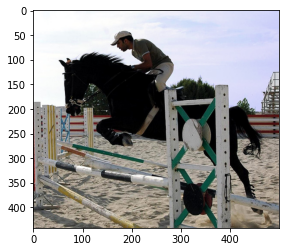

/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.         0.10098522 0.38095238 0.92118227 0.        ]
 [0.         0.         0.12605042 0.29802956 1.        ]]


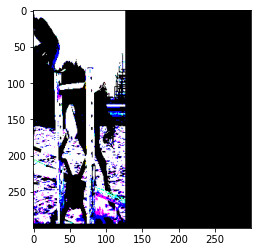

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


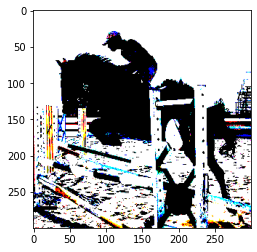

In [ ]:
# 動作確認

# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)
# 3. 元画像を表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123) # BGRの色の平均値
input_size = 300 # 画像のinputサイズを300×300
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = 'train'
img_transformed, boxes, labels = transform(img, phase, anno_list[:,:4], anno_list[:,4])
gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
print(gt)
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. val画像の表示
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, anno_list[:,:4], anno_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
anno_list = transform_anno(train_anno_list[0], width, height)

In [ ]:
anno_list

array([[0.104     , 0.19457014, 0.94      , 0.9479638 , 0.        ],
       [0.314     , 0.09728507, 0.576     , 0.37556561, 1.        ]])

## Datasetを作成
PyTorchのDatasetクラスを継承しVOCDatasetクラスを作成

関数`__get__item()`で前処理をした画像とアノテーションを取得できるようにする。
画像データはopencvで読み込んだデータ形式が[高さ][幅][色BGR]になっているため、
[色RGB][高さ][幅]になるように変換する。

In [ ]:
from torch.utils.data import Dataset
class VOCDataset(Dataset):
  '''
  VOC2012のDatasetを定義するクラス

  Attribute
  -------------
  img_list: リスト
    画像のパスを格納したリスト
  anno_list: リスト
    アノテーションへのパスを格納したリスト
  phase: 'train' or 'val'
    訓練か検証かを設定する
  transform: object
    前処理クラスのインスタンス
  transform_anno: object
    xmlのアノテーションをリストに変換するインスタンス
  '''

  def __init__(self, img_list, anno_list, phase, transform, transform_anno):
    self.img_list = img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform
    self.transform_anno = transform_anno

  def __len__(self):
    '''画像の枚数を返す'''
    return len(self.img_list)

  def __getitem__(self, index):
    '''
    前処理をした画像のテンソル形式のデータとアノテーションを取得
    '''
    im, gt, h, w = self.pull_item(index)
    return im, gt

  def pull_item(self, index):

    # 1. 画像ファイルの読み込み
    image_file_path = self.img_list[index]
    img = cv2.imread(image_file_path)
    height, width, channel = img.shape

    # 2. アノテーションをリストに変換
    anno_file_path = self.anno_list[index]
    anno_list = self.transform_anno(anno_file_path, width, height)

    # 3. 前処理を実施
    img, boxes, labels = self.transform(img, self.phase, anno_list[:,:4], anno_list[:,4])

    # 色チャネルの変換
    # 次元入れ替え
    img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)

    # BBoxとラベルをセットにしたnp.arrayを作成、gtはground truthの略称
    gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

    return img, gt, width, height

In [ ]:
# 動作確認
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', 
                           transform=DataTransform(input_size, color_mean), 
                           transform_anno=Anno_xml2list(voc_classes))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', 
                           transform=DataTransform(input_size, color_mean), 
                           transform_anno=Anno_xml2list(voc_classes)
                        )
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# 3. DataLoaderの実装
データをミニバッチとして取り出すためのクラスDataLoaderを実装する。ここで実装するDataLoaderもSSD固有のものではなくその他の物体検出モデルでも作成できる。

## DataLoaderを作成
画像分類の場合、PyTorch標準のDataLoaderを使えばよかったが、物体検出の場合はアノテーションデータの情報、変数gtのサイズが画像ごとに異なるため、独自のDataLoaderを準備する必要がある。Datasetから取り出す変数gtはリスト型変数になっていて、要素数は画像にある物体数、各要素は5つの変数
  
    `[xmin, ymin, xmax, ymax, class_index]`

となっている。


Detasetから取り出す変数のサイズがデータごとに異なる場合、DataLoaderクラスにおいてデフォルトで用意されているデータ取り出し関数`collate_fn`を別途作る必要がある。
今回はこのデータ取り出し関数として`od_collate_fn`を作成する。odはobject detectionの略。


In [ ]:
def od_collate_fn(batch):
  '''
  Datasetから取り出すアノテーションデータのサイズが画像ごとに異なることに対応するcollate_fnをカスタマイズした関数
  collate_fnはPyTorchでリストからmini-batchを作成する関数
  ミニバッチ分の画像が並んでいるリスト変数batchに
  ミニバッチ番号を指定する次元を先頭に一つ追加してリストの形を変形する
  '''
  targets = []
  imgs = []

  for sample in batch:
    imgs.append(sample[0]) # 画像
    targets.append(torch.FloatTensor(sample[1])) # アノテーションのgt


  imgs = torch.stack(imgs, dim=0) # torch.Size([batch_num, 3, 300, 300]) channel, width, height

  return imgs, targets

In [ ]:
from torch.utils.data import DataLoader
batch_size = 4

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict['val'])
images, targets = next(batch_iterator)
print(images.size())
print(len(targets))
print(targets[0].size()) # アノテーション正解データ 物体数分だけ

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [ ]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


# 4. ネットワークモデルの実装
SSDではバウンディングボックス(BBox)と元になるさまざまな大きさのデフォルトボックス(DBox)を用意するのであった。このDBoxをどのように実装するのか理解することが重要となる。

また、SSDのネットワークモデルは4つのモジュールから構成される。本節ではまずネットワークモデルの全体像を概観し、その後、4つのモジュールをそれぞれ構築していく。

本節の学習目標は以下のようになる。
1. SSDのネットワークモデルを構築している4つのモジュールを把握する
2. SSDのネットワークモデルを作成できるようになる
3. SSDに使用する様々な大きさのデフォルトボックスの実装方法を理解する

## SSDネットワークモデルの概要
SSDのネットワークモデルの出力は8,732個のDBoxに対するオフセット情報(4変数$\Delta c_x, \Delta c_y, \Delta w, \Delta h$)と21種類の各クラスに対する確信度となる。

SSDの主なサブネットワークは、vgg、extra、loc、confの4つになる。

1. 入力画像がvgg16モジュールに入力される
  - vggモジュールはVGG16モデルを基調としている
  - 畳み込み層のカーネルサイズや使用するユニットがVGG16モデルと同じ
  - 各ユニットでの特徴量マップのサイズが異なる
2. vggで10回の畳み込みを受けたデータをL2Norm層で正規化してsource1とする
  - source1はチャネル数512、特徴量マップの大きさは$38\times 38$
3. vggでさらに5回、合計15回の畳み込み計算を受けたvggモジュールの出力をsource2とする
  - source2は特徴量マップの大きさが$19 \times 19$になっている
4. source2をextraモジュールへ入力する
  - MaxPoolingは使用しない
  - 畳み込み処理を8回使用
  - 2回畳み込むごとにsource3~6として出力する
  - 各sourceの特徴マップのサイズは$10\times 10$, $5\times 5$, $3\times 3$, $1\times 1$
  - source1は元の$300\times 300$に画像サイズが$38\times 38=1444$個の領域に対するそれぞれの特徴量が求まっている。つまり元の画像1/38の領域ごとに1つの物体を検出しようとしている。
  - source6では$1\times 1=1$個の領域に対する値が求まっている。つまりsource6は元の画像において画像全面にわたる大きな1つの物体を検出しようとしているということ。
  - source1~source6を作成することで、画像内のさまざまな大きさの物体を想定した特徴量を得ることができる。

    source1~source6で畳み込みの処理が異なることに注意する必要がある。特徴量マップのサイズが大きい(小さな物体に着目する)source1は畳み込み処理の回数が特徴量マップのサイズが小さいsource6と比べて少ないため、SSDでは小さな物体の検出が苦手という特徴がある。その結果、小さな物体検出精度が大きな物体検出精度よりも低くなってしまう。

5. locモジュールでは各sourceに対して1回ずつ畳み込み処理を行い8,732個のDBoxに対するオフセット情報(4変数)を出力する

6. confモジュールで一度畳み込み処理を実施し、8,732個のDBoxに対する20クラス+背景クラスの合計21クラスに対する各クラスの確信度を出力


8,732個のDBoxの内訳は
$$
38\times 38\times 4+ 19\times 19\times 6 + 10\times 10 \times 6 + 5\times 5\times 6 + 3\times 3 \times 4 + 1\times 1\times 4 = 8732
$$
となっている。各sourceで複数のDBoxを使用して物体検出を行うことでよりよい特徴量の抽出が可能となる。



## vggモジュールを実装
vggを実装する関数`make_vgg`を定義する。Conv、ReLU、MaxPoolingを合計35ユニット用意する。
35回繰り返してユニットを定義するのは大変なのでコンフィグレーション変数として
  `cfg = [64, 64, 'M', ...]`
を作成し、要素の値に応じてユニットを作成する。

cfgの説明
- 'M': MaxPooling層
- 'MC': ceilモードのMaxPooling層
MaxPooling層の出力テンソルのサイズを計算する際、デフォルトではfloor(床関数)モードになっているのでceilモードにして小数点以下を切り上げるように設定する。

ReLUの引数inplaceはReLUへの入力をメモリ上に保持するか、それとも書き換えるかの設定。


In [ ]:
import torch.nn as nn
# 35層にわたる、vggモジュールを作成
def make_vgg():
  layers = []
  in_channels = 3 # 色チャネル数

  # vggモジュールで使用する畳み込み層やMaxPoolingのチャネル数
  cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    elif v == 'MC':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)] # ceil_mode
    else:
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
      layers += [conv2d, nn.ReLU(inplace=True)] # 入力を書き換える
      in_channels = v
    
  pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
  conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
  conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
  layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
  return nn.ModuleList(layers)

vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

## extraモジュールを実装
extraを実装する`make_extras`を実装する。source3~source6を計算するための畳み込み層を8ユニット並べる。今回はReLUをSSDモデルの順伝播関数の中で用意することにし、extraモジュールでは用意していない。

In [ ]:
def make_extras():
  layers = []
  in_channels = 1024 # vggモジュールから出力されたextraに入力される画像チャネル数

  # extraモジュールの畳み込み層のチャネル数を設定するconfiguration
  cfg = [256, 512, 128, 256, 128, 256, 128, 256]

  layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=1)]
  layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=3, stride=2, padding=1)]
  layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=1)]
  layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=3, stride=2, padding=1)]
  layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=1)]
  layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=3)]
  layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=1)]
  layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=3)] 

  return nn.ModuleList(layers)

extras = make_extras()
print(extras)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


## locモジュールとconfモジュールを実装
locとconfを作成する`make_loc_conf`を実装する。引数のbbox_aspect_numで各sourceで使用するDBoxの数を設定している。

In [ ]:
# デフォルトボックスのオフセットを出力するloc_layers
# デフォルトボックスに対する各クラスの確信度confidenceを出力するconf_layersを作成

def make_loc_conf(num_classes=21, bbox_aspect_num=[4,6,6,6,4,4]):
  loc_layers = []
  conf_layers = []

  # source1に対する畳み込み層
  loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]*4, kernel_size=3, padding=1)] # ×4はオフセット変数の個数
  conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]*num_classes, kernel_size=3, padding=1)] 
  
  # source2に対する畳み込み層
  loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]*4, kernel_size=3, padding=1)] # ×4はオフセット変数の個数
  conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]*num_classes, kernel_size=3, padding=1)] 
  
  # source3に対する畳み込み層
  loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]*4, kernel_size=3, padding=1)] # ×4はオフセット変数の個数
  conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]*num_classes, kernel_size=3, padding=1)] 
  
  # source4に対する畳み込み層
  loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]*4, kernel_size=3, padding=1)] # ×4はオフセット変数の個数
  conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]*num_classes, kernel_size=3, padding=1)] 
  
  # source5に対する畳み込み層
  loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]*4, kernel_size=3, padding=1)] # ×4はオフセット変数の個数
  conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]*num_classes, kernel_size=3, padding=1)] 
  
  # source6に対する畳み込み層
  loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]*4, kernel_size=3, padding=1)] # ×4はオフセット変数の個数
  conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]*num_classes, kernel_size=3, padding=1)] 
  
  return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## L2Norm層を実装
L2Norm層はチャネルごとに特徴量マップの統計的性質が異なる点を正規化する。
全チャネルの特徴量マップのL2ノルムで各チャネルの各セルを割り算することで正規化する。

このようにチャネル方向に正規化することで、チャネルごとに特徴量の大きさが著しく異なる状況を修正する。

さらにL2Norm層では正規化した512チャネル×38×38のテンソルに対して、チャネルごとに係数を掛け算する。これらの係数は学習対象である。

In [ ]:
# scale=20のL2Normで正規化する層
class L2Norm(nn.Module):
  def __init__(self, input_channels=512, scale=20):
    super().__init__() # 親クラスのコンストラクタ
    self.weight = nn.Parameter(torch.Tensor(input_channels)) # 512個のパラメータを生成
    self.scale = scale # 係数weightの初期値として設定する値
    self.reset_parameters() # パラメータを初期化
    self.eps = 1e-10 # 0除算防止

  def reset_parameters(self):
    nn.init.constant_(self.weight, self.scale) # weightの値がすべてscaleとなる

  def forward(self, x):

    # normのテンソルサイズはtorch.Size([batch_num, 1, 38, 38])となる
    norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps
    x = torch.div(x, norm)

    weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) # xと同じサイズに拡張
    out = weights * x
    
    return out

In [ ]:
# 動作理解
import torch
weight = nn.Parameter(torch.Tensor(512))
# print(weights) # ランダムに初期かれた重みパラメータ
weight = nn.init.constant_(weight, 20)
# print(weights) # 20で初期化された重みパラメータ
print(weight.size())
batch_num = 4
in_channels = 512
img_size = 38
x = torch.randn(batch_num, in_channels, img_size, img_size)
norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + 1e-4
x = torch.div(x, norm)
# print(x.size()) # torch.Size([4, 512, 38, 38])
print('\n','weights size','\n')
weights = weight.unsqueeze(0)
print(weights.size())
weights = weights.unsqueeze(2)
print(weights.size())
weights = weights.unsqueeze(3)
print(weights.size())
weights = weights.expand_as(x)
print(weights.size())

torch.Size([512])

 weights size 

torch.Size([1, 512])
torch.Size([1, 512, 1])
torch.Size([1, 512, 1, 1])
torch.Size([4, 512, 38, 38])


## デフォルトボックスを実装
8,732個のデフォルトボックスを用意するクラスを作成する。source1~source6までの大きさが異なる特徴量マップに対して、それぞれ4もしくは6種類のDBoxを作成している。

DBoxの種類が
- 4種類の場合
  - 小さい正方形
  - 大きい正方形
  - 1:2の比率の長方形
  - 2:1の比率の長方形
- 6種類の場合
  - 前述の4種類の矩形
  - 3:1の比率の長方形
  - 1:3の比率の長方形
  
のDBoxを用意する

In [ ]:
# productの使用方法
import itertools
for i, j in itertools.product(range(3), repeat=2):
  print(i,j)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [ ]:
feature_maps = ssd_cfg['feature_maps']
steps = ssd_cfg['steps']
count=0
for k, f in enumerate(feature_maps):
  for i, j in itertools.product(range(f), repeat=2):
    f_k = 300 / steps[k]

    cx = (j+0.5) / f_k
    cy = (i+0.5) / f_k
    if k==0:
      count+=1
      print(i,j)    
    #print(cx, cy)
  if k==0:
    print('f_k',f_k)  
print(count)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
4 20
4 21
4 22
4 23
4 24
4 25
4 26
4 27
4 28
4 29
4 30
4 31
4 32
4 33
4 34
4 35
4 36
4 37
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
5 20
5 21


In [ ]:
from math import sqrt
# デフォルトボックスを出力するクラス
class DBox(object):
  def __init__(self, cfg):
    super().__init__()

    # 初期設定
    self.image_size = cfg['input_size']
    # [38, 19, ...] 各sourceの特徴量マップのサイズ
    self.feature_maps = cfg['feature_maps']
    self.num_priors = len(cfg['feature_maps']) # sourceの個数=6
    # DBox=[cx, cy, w, h]
    self.steps = cfg['steps'] # [8, 16,  ...] DBoxのピクセルサイズ
    self.min_sizes = cfg['min_sizes'] # [30, 60, ...] 小さい正方形のDBoxのピクセルサイズ
    self.max_sizes = cfg['max_sizes'] # [60, 111, ...] 大きい正方形のDBoxのピクセルサイズ
    self.aspect_ratios = cfg['aspect_ratios'] # 長方形のDBoxのアスペクト比
  
  def make_dbox_list(self):
    mean = []
    # 'feature_map': [38, 19, 10, 5, 3, 1]
    for k, f in enumerate(self.feature_maps):
      for i, j in itertools.product(range(f), repeat=2):
        
        # 特徴量の画像サイズ
        # 300 / 'steps': [8, 16, 32, 64, 100, 300]
        f_k = self.image_size / self.steps[k] # f_k == fになっている

        # DBoxの中心座標 0-1で規格化している
        cx = (j+0.5) / f_k
        cy = (i+0.5) / f_k

        # アスペクト比1の小さいDBox [cx, cy, width, height]
        # 'min_sizes' : [30, 60, 111, 162, 213, 264]
        s_k = self.min_sizes[k] / self.image_size
        mean += [cx, cy, s_k, s_k]

        # アスペクト比1の大きいDBox [cx, cy, width, height]
        # 'max_sizes' : [60, 111, 162, 213, 264, 315]
        s_k_prime = sqrt(s_k * (self.max_sizes[k] / self.image_size))
        mean += [cx, cy, s_k_prime, s_k_prime]

        # その他のアスペクト比のDBox
        for ar in self.aspect_ratios[k]:
          mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
          mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
          
    # DBoxをテンソルに変換 torch.Size([8732, 4])
    output = torch.Tensor(mean).view(-1, 4)
    print(output.size())

    # DBoxが外にはみ出るのを防ぐために大きさをmin0-max1にする
    output.clamp_(max=1, min=0)

    return output

In [ ]:
import math
for k, step in enumerate(steps):
  print(math.ceil(300/steps[k]))

38
19
10
5
3
1


In [ ]:
import pandas as pd

# 動作確認
# SSD300の設定
ssd_cfg = {
    'num_classes': 21,
    'input_size': 300,
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes' : [30, 60, 111, 162, 213, 264],
    'max_sizes' : [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2,3], [2,3], [2,3], [2], [2]]
}

dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

pd.DataFrame(dbox_list.numpy())

torch.Size([8732, 4])


,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


## SSDを実装
これまでに作成したモジュールを使用してクラスSSDを実装する。クラスSSDには次節で順伝播のメソッドを定義する。訓練時と推論時には異なる動作をし、推論時にはクラスDetectを用いる。Detectは次節で実装する。

In [ ]:
# SSDクラスを作成する
class SSD(nn.Module):
  def __init__(self, phase, cfg):
    super().__init__()

    self.phase = phase
    self.num_classes = cfg['num_classes']

    # SSDのネットワーク
    # インスタンス変数の名前がそのままモジュールの名前になる
    self.vgg = make_vgg()
    self.extras = make_extras()
    self.L2Norm = L2Norm()
    self.loc, self.conf = make_loc_conf(cfg['num_classes'], cfg['bbox_aspect_num'])

    # DBox作成
    dbox = DBox(cfg)
    self.dbox_list = dbox.make_dbox_list()

    if phase == 'inference':
      self.detect = Detect()

# 動作確認
ssd_test = SSD(phase='train', cfg=ssd_cfg)
print(ssd_test)

torch.Size([8732, 4])
SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

# 5. 順伝播関数のの実装
画像分類で使用したネットワークにおけるforward関数は単純にモデル内の層を前から後ろに処理しただけだったが、物体検出では複雑な順伝播処理が必要となる。新たな概念として**Non-Maximum Suppresion**と呼ばれる手法が登場する。

本節の達成目標は
1. Non-Maximum Suppresionを理解する
2. SSDの推論時に使用するDetectクラスの順伝播を理解する
3. SSDの順伝播を実装できるようになる


## 関数decodeを実装
SSDの推論時に使用するクラスDetectの中で使用する関数decodeとnm_supressionを実装する。

decodeは${\rm DBox} = (cx_d, cy_d, w_d, h_d)$とSSDモデルから求めたオフセット情報$loc = (\Delta cx, \Delta cy, \Delta w, \Delta h)$を使用し、BBoxの座標を生成する関数である。

BBoxはDBoxの情報を用いて次のように求められる。
\begin{align}
  cx &= cx_d + 0.1\Delta cx \times w_d \\
  cy &= cy_d + 0.1\Delta cy \times h_d \\
  w &= w_d \times {\rm exp}(0.2\Delta w) \\
  h &= h_d \times {\rm exp}(0.2\Delta h) 
\end{align}

この式を用いてBBoxの座標の表示形式を$(cx, cy, w, h)$から$(x_{min}, y_{min}, x_{max}, y_{max})$に変換する。

In [ ]:
def decode(loc, dbox_list):
  '''
  オフセット情報を用いてDBoxからBBoxを求める

  '''

  boxes = torch.cat((dbox_list[:,:2] + 0.1*loc[:,:2] * dbox_list[:,2:], 
                     dbox_list[:,2:] * torch.exp(0.2*loc[:,2:])), dim=1)
  
  # BBoxの座標の表示形式を変換
  boxes[:,:2] -= boxes[:,2:]/2 #[c_x-w/2, c_y-h/2] = [x_min, y_min]
  boxes[:,2:] += boxes[:,:2] # [w+x_min, h+y_min] = [x_max, y_max]

  return boxes

## Non-Maximum Suppressionを行う関数を実装
8732個のDBoxからBBoxを計算すると同じ物体に対して異なるBBoxがわずかだけずれて複数個フィッティングされることがある。このような冗長なBBoxを除去し、1つの物体に対して1つのBBoxだけを対応させるようにするのがNon-Maximum Supressionである。
BBoxのかぶり度合いを**IOU**という。

**アルゴリズム**<br>
同じ物体クラスを指し示すBBoxが複数ある場合に、もしBBox同士のかぶっている面積がしきい値(`overlap`)以上である場合は冗長なBBoxであると判定する。そして検出の確信度が最も大きい値のBBoxのみを残す。

In [ ]:
# 実装理解
a = torch.randn(3,2, dtype=float, device='cuda:0')
print(a)
print(a.size())
b = a.new() # aと同じdtype, deviceを持つTensorを生成
print(b)
c = a.new(a.size(0))
print(c)
c = c.zero_()
print(c)
c = c.long() # 整数型に変換
print(c)

tensor([[ 1.0356, -0.6802],
        [-0.2511,  0.2090],
        [ 0.8086,  0.4190]], device='cuda:0', dtype=torch.float64)
torch.Size([3, 2])
tensor([], device='cuda:0', dtype=torch.float64)
tensor([ 1.0356, -0.6802, -0.2511], device='cuda:0', dtype=torch.float64)
tensor([0., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0, 0, 0], device='cuda:0')


In [ ]:
# 実装理解
scores = torch.randn(8732)
#print(scores)
#print(scores.sort(0)) # 昇順
v, idx = scores.sort(0)
#print(idx.numel())
idx = idx[-200:]
#print(idx)
max_index = idx[-1]
print('max_idx', max_index)

boxes = torch.rand(8732, 4)
print(boxes)
x1 = boxes[:,0]
y1 = boxes[:,1]
x2 = boxes[:,2]
y2 = boxes[:,3]
area = torch.mul(x2-x1, y2-y1)

tmp_x1 = boxes.new()
tmp_y1 = boxes.new()
tmp_x2 = boxes.new()
tmp_y2 = boxes.new()
tmp_w = boxes.new()
tmp_h = boxes.new()

torch.index_select(x1, 0, idx, out=tmp_x1)
torch.index_select(y1, 0, idx, out=tmp_y1)
torch.index_select(x2, 0, idx, out=tmp_x2)
torch.index_select(y2, 0, idx, out=tmp_y2)

print(tmp_x1.size())
print(tmp_y1.size())

tmp_x1 = torch.clamp(tmp_x1, min=x1[max_index])
tmp_y1 = torch.clamp(tmp_y1, min=y1[max_index])
tmp_x2 = torch.clamp(tmp_x2, max=x2[max_index])
tmp_y2 = torch.clamp(tmp_y2, max=y2[max_index])

print(tmp_x1.size())
print(tmp_y1.size())
print(tmp_x2.size())
print(tmp_y2.size())

tmp_w.resize_as_(tmp_x2)
tmp_h.resize_as_(tmp_y2)

print(tmp_w.size())
print(tmp_h.size())

tmp_w = tmp_x2 - tmp_x1
tmp_h = tmp_y2 - tmp_y1
inter_area = tmp_w * tmp_h
print(inter_area)

rem_areas = torch.index_select(area, 0, idx) # conf上位200のBBoxの面積を取り出す
union_area = (rem_areas - inter_area) + area[max_index] 

IOU = inter_area / union_area
#print(IOU < 0.45)
#print(IOU.le(0.45))
idx[IOU<0.45].size()

max_idx tensor(6028)
tensor([[0.7442, 0.2364, 0.1089, 0.3804],
        [0.8021, 0.7042, 0.8499, 0.0958],
        [0.2475, 0.7071, 0.9166, 0.4401],
        ...,
        [0.6742, 0.9112, 0.1237, 0.4628],
        [0.5993, 0.6968, 0.2589, 0.8279],
        [0.2482, 0.2716, 0.5220, 0.7744]])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([200])
tensor([ 1.8643e-01,  1.3084e-01,  5.5442e-01,  1.3597e-01,  4.1491e-01,
         5.3428e-01,  3.2607e-01, -3.0131e-02,  2.8172e-01,  4.5585e-01,
         3.3180e-01,  5.6570e-01,  2.5602e-01,  7.7545e-02,  5.9322e-02,
        -4.7989e-02,  7.2775e-01,  1.2084e-01,  9.7321e-02,  4.1294e-01,
         4.8636e-01,  3.2653e-01,  1.9860e-01,  4.8776e-01,  7.1840e-02,
         4.1616e-01,  1.3024e-01,  2.1305e-01, -2.5610e-02,  4.3258e-01,
         4.3120e-01,  9.0142e-02,  8.5080e-02, -3.0131e-02, -2.4219e-02,
         6.1211e-01,  4.6584e-01, -4.0010e-02,  3.1961e-01

torch.Size([188])

In [ ]:
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
  '''
  Non-Maximul Suppresion
  boxesのうち被りすぎ(overlap以上)のBBoxを削除する
  
  Parameters
  ----------------------
  boxes: [確信度しきい値(0.01)を超えたBBox数, 4]
          BBox情報
  scores: [確信度しきい値(0.01)を超えたBBox数]
          confの情報
  
  Returns
  -----------------------
  keep: リスト
        confの降順にnmsを通過したindexが格納
  count: int
        nmsを通過したBBoxの数

  '''

  # returnのひな型を作成
  count = 0
  keep = scores.new(scores.size(0)).zero_().long() # scoreと同じ要素数の0からなるtensorを作成

  # 各BBoxの面積areaを計算
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
  area = torch.mul(x2-x1, y2-y1)

  # boxesと同じdtypeとdeviceを持つTensorを生成
  # BBoxのかぶり度合いIOUの計算に使用する際のひな型
  tmp_x1 = boxes.new()
  tmp_y1 = boxes.new()
  tmp_x2 = boxes.new()
  tmp_y2 = boxes.new()
  tmp_w = boxes.new()
  tmp_h = boxes.new()

  # scoreを昇順に並び替え
  v, idx = scores.sort(0)

  idx = idx[-top_k:]

  # idxの要素数が0でない限りループ
  while idx.numel() > 0:
    i = idx[-1] # conf最大のインデックス

    # keepにconf最大のインデックスを格納
    # nmsを通過するBBoxの数をカウント
    keep[count] = i
    count += 1

    # idxの要素数が1になった時点でストップ
    if idx.size(0) == 1:
      break

    # conf最大のインデックスを削除
    idx = idx[:-1]

    torch.index_select(x1, dim=0, index=idx, out=tmp_x1)
    torch.index_select(y1, dim=0, index=idx, out=tmp_y1)
    torch.index_select(x2, dim=0, index=idx, out=tmp_x2)
    torch.index_select(y2, dim=0, index=idx, out=tmp_y2)

    # すべてのBBoxに対して現在(index==i)のBBoxと被っている値までに設定
    tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
    tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
    tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
    tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

    tmp_w.resize_as_(tmp_x2)
    tmp_h.resize_as_(tmp_y2)

    # clampした状態でのBBoxの幅と高さを求める
    tmp_w = tmp_x2 - tmp_x1
    tmp_h = tmp_y2 - tmp_y1

    # clampされた状態での面積を求める
    inter = tmp_w * tmp_h

    # IOU
    rem_areas = torch.index_select(area, 0, idx) # conf最大のBBoxと被っている領域の面積を取り出す
    union = (rem_areas - inter) + area[i] # 2つのエリアの和の面積

    IOU = inter / union

    idx = idx[IOU <= overlap]
    # idx = idx[IOU.le(overlap)]
  
  return keep, count

## クラスDetectを作成
推論時の最後にDetectを適用し、テンソルサイズ(batch_num, 21, 200, 5)のテンソルを出力する。

**Detectへの入力**
- locモジュールの出力(batch_num, 8732, 4)
- confモジュールの出力(batch_num, 8732, 21)
- デフォルトボックスの情報(8732, 4)

confの出力にはソフトマックス関数を適用し規格化しておく。

Detectはforwardで順伝播関数をよびだすようにするため`torch.aotograd.Function`を継承させる。

**Detectのforwardの流れ**
1. decodeでDBoxとオフセットの情報をBBoxの情報に変換
2. confがしきい値以上のBBoxを取り出す
3. Non-Maximum Suppressionで同一物体に対して被りがあるBBoxを消去



In [ ]:
class Detect(torch.autograd.Function):
  def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
    self.softmax = nn.softmax(dim=-1)
    self.conf_thresh = conf_thresh # 確信度のしきい値 これを超えるDBoxを取り出す
    self.top_k = top_k # 確信度が上位200位のBBoxのnon-maximum supressionを考慮する
    self.nms_thresh = nms_thresh # IOUがこの値よりも大きいBBoxは同じ物体を囲んでいるので消去

  def __forward__(self, loc_data, conf_data, dbox_list):
    '''
    順伝播の計算を実行する

    Parameters
    ------------------
    loc_data: [batch_num, 8732, 4]
      オフセット情報
    conf_data: [batch_num, 8732, 21]
      確信度情報
    dbox_list: [8732, 4]
      DBoxの情報
    
    Returns
    ------------------
    outputs: torch.Size([batch_num, 21, 200, 5])
      (batch_num, クラス, confのtop200, BBox=[conf, xmin, ymin, xmax, ymax])
    '''

    # 各サイズを取得
    num_batch = loc_data.size(0) # ミニバッチのサイズ
    num_dbox = loc_data.size(1) # 8732
    num_classes = conf_data.size(2) #クラス数

    # confにソフトマックス関数を適用して正規化
    conf_data = self.softmax(conf_data)

    # 出力の型を作成
    output = torch.zeros(num_batch, num_classes, self.top_k, 5)

    # conf_dataの軸の順番変更 [batch_num, 8732, num_classes] to [batch_num, num_classes, 8732]
    conf_preds = conf_data.transpose(2,1)

    # バッチごとの処理
    for i in range(num_batch):
      # locとDBoxからBBoxを求める
      decoded_boxes = decode(loc_data[i], dbox_list)

      # confのコピーを作成
      conf_scores = conf_preds[i].clone()

      # 画像クラスごとに処理(indexは背景クラスを除くため１から処理)
      for cl in range(1, num_classes):
        # confのしきい値を超えたBBoxを取り出す
        # confのしきい値を超えているのかのマスクを作成し
        # しきい値を超えたconfのインデックスをc_maskとして取得
        c_mask = conf_scores[cl] > self.conf_thresh
        # c_mask = conf_scores[cl].gt(self.conf_thresh)
        # gtはgreater thanのこと
        
        scores = conf_scores[cl][c_mask]

        # しきい値を超えるBBoxが存在しない場合socres=[]の場合 何もしない
        if scores.nelement() == 0:
          continue
        
        # c_maskをdecoded_boxesに適用できるようにサイズを変更する
        l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
        # l_mask: torch.Size([8732, 4])

        # l_maskをdecoded_boxesに適用
        boxes = decoded_boxes[l_mask].view(-1, 4)
        # decoded_boxes[l_mask]で1次元になってしまうので
        # [しきい値を超えたBBox数, 4]に変換

        # non-maximum suppressionを実施し、被っているBBoxを取り除く
        ids, count = nm_suppression(boxes, scores, self.nms_thresh, self.top_k)
        # ids: confの降順にnon-maximum suppressionを通過したindexのリスト
        # count: non-maximum suppressionを通過したBBoxの数

        output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), dim=1)

      
    return output # torch.Size([num_batch,21,200,5])

In [ ]:
# 実装理解

#乱数固定
torch.manual_seed(0)
# nn.Softmax(dim=i) dim方向に足し合わせると合計1になるように正規化
conf_data = torch.rand(8732,21)
#print(conf_data[:,0])
softmax = nn.Softmax(dim=0)
conf_preds = softmax(conf_data).transpose(1,0)
print(conf_preds[:,0])
#print(conf_preds.sum(dim=0))
print(conf_preds.size())


'''c_mask = conf_scores[cl].gt(self.conf_thresh) はインデックスを取得しているのか
'''
cl = 14
conf_scores = conf_preds.clone()
print(conf_scores[:,cl])
conf_thresh = 1e-4
c_mask = conf_scores[cl] > conf_thresh
print(conf_scores[cl].gt(conf_thresh))
print(c_mask)
print(c_mask.size())

scores = conf_scores[cl][c_mask]

print(scores.nelement())
print(type(scores.nelement()))

print(c_mask.unsqueeze(1).size())

tensor([1.0986e-04, 1.4363e-04, 7.2618e-05, 7.5809e-05, 9.0666e-05, 1.2570e-04,
        1.0840e-04, 1.6353e-04, 1.0504e-04, 1.2474e-04, 9.4443e-05, 9.9554e-05,
        6.7938e-05, 7.9386e-05, 8.9574e-05, 1.1134e-04, 1.3344e-04, 1.4815e-04,
        7.7712e-05, 8.8934e-05, 1.3132e-04])
torch.Size([21, 8732])
tensor([9.8540e-05, 8.0705e-05, 1.5486e-04, 7.5488e-05, 1.3491e-04, 9.2917e-05,
        8.6015e-05, 1.2035e-04, 8.4687e-05, 1.2262e-04, 1.2118e-04, 7.5773e-05,
        1.1905e-04, 1.3679e-04, 1.3417e-04, 1.0263e-04, 7.2679e-05, 1.0161e-04,
        1.2975e-04, 9.2129e-05, 1.3240e-04])
tensor([False, False,  True,  ...,  True, False,  True])
tensor([False, False,  True,  ...,  True, False,  True])
torch.Size([8732])
5221
<class 'int'>
torch.Size([8732, 1])


In [ ]:
import warnings
warnings.simplefilter('ignore')
torch.manual_seed(0)
loc_data = torch.rand(8732,4)
decoded_box = decode(loc_data, dbox_list)
l_mask = c_mask.unsqueeze(1).expand_as(decoded_box)
print(l_mask.size())
boxes = decoded_box[l_mask]
print(boxes.size()) # 1次元になってしまう
boxes = boxes.view(-1,4)
print(boxes.size())

top_k=200
nms_thresh=0.45
ids, count = nm_suppression(boxes, scores, nms_thresh, top_k)
print(ids.size(), count)

torch.Size([8732, 4])
torch.Size([20884])
torch.Size([5221, 4])
torch.Size([5221]) 31


## SSDモデルを実装
soure1~source6を得るまでの実装は前のSSDネットワークモデルの概要に記載したとおりである。

最終的に各モジュールの出力サイズは
- オフセットloc (batch_num, 8732, 4)
- 確信度conf (batch_num, 8732, 21)
- DBox dbox_list (8732, 4)
となり、これらをoutputにまとめる

学習時は`output = (loc, conf, dbox_list)`が出力となる。

推論時はこのoutputをさらにDetectの順伝播関数に投入し、最終的に検出されたBBoxの情報(batch_num, 21, 200, 5)を出力する

ミニバッチ次元を持ちながらsourceごとにDBoxの数が4もしくは6で異なることに注意して実装する。

In [ ]:
from torch.nn import functional as F

class SSD(nn.Module):
  def __init__(self, phase, cfg):
    super().__init__()

    self.pahse = phase # train or inference
    self.num_classes = cfg['num_classes']

    # SSDのネットワークを作る
    self.vgg = make_vgg()
    self.L2Norm = L2Norm()
    self.extras = make_extras()
    self.loc, self.conf = make_loc_conf(self.num_classes, cfg['bbox_aspect_num'])

    # DBox作成
    dbox = DBox(cfg)
    self.dbox_list = dbox.make_dbox_list()

    # 推論時は「Detect」を使用
    if phase == 'inference':
      self.detect = Detect()
    
    def forward(self, x):
      sources = list() # locとconfへの入力source1～source6を格納
      loc = list() # locの出力
      conf = list() # confの出力

      # vggのconv4_3まで計算する
      for k in range(23):
        x = self.vgg[k](x)

      # conv4_3の出力をL2Normに入力し、source1を作成 sourcesに追加
      source1 = self.L2Norm(x)
      sources.append(source1)

      # vggを最後まで計算し、source2を作成、sourcesに追加
      for k in range(23, len(self.vgg)):
        x = self.vgg[k](x)
      sources.append(x)

      # extrasのconvとReLUを計算
      for k, v in enumerate(self.extras):
        x = F.relu(v(x), inplace=True)
        if k % 2==1: # conv -> ReLU -> conv -> ReLU をしたらsourceに入れる
          sources.append(x)

      for (x, l, c) in zip(sources, self.loc, self.conf):
        loc.append(l(x).permute(0, 2, 3, 1).contiguous()) # permuteで軸の番号入れ替え
        conf.append(c(x).permute(0, 2, 3, 1).contiguous())
        # l(x), c(x)で畳み込みを実行
        # l(x), c(x)の出力サイズは[batch_num, 4*アスペクト比の種類数, featuremapの高さ, featuremapの幅]
        # sourceによって、アスペクト比の種類数が異なり、面倒なので順番入れ替えてそろえる
        # [ミニバッチ数, featuremap数, featuremap数, 4*アスペクト比の種類数]
        # torch.contiguous()はメモリ上で要素を連続的に配置し直す操作
        # viewを行うためには要素がメモリ上で連蔵的に配置されていなければならない
        
        # loc.size() = torch.Size([batch_num, 34928])
        # conf.size() = torch.Size([batch_num, 183372])
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], dim=1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], dim=1)

        # さらにlocとconfを整形する
        # loc.size() = torch.Size([batch_num, 8732, 4])
        # conf.size() = torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 最後に出力する
        output = (loc, conf, self.dbox_list)

        if self.pahse == 'inference':
          return self.detect(output[0], output[1], output[2]) # torch.Size([batch_num, 21, 200, 5])
        else:
          return output # (loc, conf, dbox_list)のタプル

In [ ]:
# 実装理解

# sources = [torch.rand(v) for v in [512, 1024, 512, 256, 256, 256]]
sources = [torch.rand(1, ic, fms, fms) for ic, fms in [(512, 38), (1024, 19), (512, 10), (256, 5), (256, 3), (256, 1)]]
#source1 = torch.rand(1,512, 38, 38)

loc, conf = make_loc_conf(21,ssd_cfg['bbox_aspect_num'])
print(loc)
print(conf)

print(loc[0](sources[0]).size()) # [batch_num, bbox_aspect_num*4, feature_map.size(0), feature_map.size(1)]

'''s1 = loc[0](sources[0]).permute(0, 2, 3, 1)
s1.view(s1.size(0), -1) # エラー
'''
s1 = loc[0](sources[0]).permute(0, 2, 3, 1).contiguous()
print(s1.view(s1.size(0), -1).size())

'''for x, l, c in zip(sources, loc, conf):
  print(l(x).size())
  print(l(x).permute(0, 2, 3, 1).size())
  print(type(l(x).permute(0, 2, 3, 1)))'''

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
torch.Size([1, 16, 38, 38])
torch.Size([1, 23104])


'for x, l, c in zip(sources, loc, conf):\n  print(l(x).size())\n  print(l(x).permute(0, 2, 3, 1).size())\n  print(type(l(x).permute(0, 2, 3, 1)))'

# 6. 損失関数の実装
ここで定義する損失関数の値が小さくなるようにネットワークモデルが学習する。
ニューラルネットワークの結合パラメータを更新・学習させることになる。

1. jaccard係数を用いてmatch関数の動作を理解する
2. Hard Negative Mining を理解する
3. 2種類の装置関数(SmoothL1loss関数、交差エントロピー誤差関数)の働きを理解する


## jaccard係数を用いたmatch関数の動作
損失関数を定義するために、8732個のDBoxから学習データの画像の正解BBoxと近いDBox(正解と物体クラスが一致していて、座標情報も近いDBox)を教師データとして抽出する必要がある。

この正解BBoxと近いDBoxの抽出にjaccard係数を使用する。
jaccard係数は次のように計算できる。

$${\rm jaccard} = \frac{{\rm correct\ BBox} \cap {\rm DBox}}{{\rm correct\ BBox} \cup {\rm DBox}} $$

jaccard係数は0~1の値を取り、2つのBoxが完全に一致していれば1になり、完全に外れていれば0になる。
なお、IOU(intersection over union)と同じ計算式である。

実装においてjaccard係数は次のように用いられる。
- jaacard係数が0.5以上となる正解BBoxを持たないDBoxの場合 <br>
そのDBoxを**Negative DBox**とし、そのDBoxの予測結果の教師データとなる正解物体のラベルを0とする。これは背景クラス(ラベル0)を認識できるようにしたいからである。
- jaacard係数が0.5以上となる正解BBoxを持たないDBoxの場合 <br>
そのDBoxを**Positive DBox**とし、jaccard係数が最も大きくなる正解BBoxの物体クラスをそのDBoxの予測結果の教師データとなる正解クラスとする。またjaccard係数が最も大きくなる正解BBoxへとDBoxを変形させるオフセット値をlocの教師データとする。

注意点
- DBoxの確信度confの情報を用いるのではなく、DBoxの座標情報、すなわち変数locのみを考慮してjaccard係数を計算している点
- DBoxを補正して推定したBBoxと正解のBBoxを用いてjaccard係数を計算しているのではなく、あらかじめ用意したDBoxと正解のBBoxについて、jaccard係数を計算している点


## Hard Negative Mining
関数matchを使用することにより、正解のBBoxとDBoxの情報から教師データ`loc_t`と`conf_t_label`を用意できる。あとは損失関数に予測結果と教師データを入力して損失値を計算するだけである。その前処理として行う操作が**Hard Negative Mining**である。
これはNegative DBoxに分類されたDBoxのうち、学習に使用するDBoxの数を絞る操作である。

オフセットの教師データ`loc_t`はPositive DBoxにのみ用意されているのでオフセット情報の損失値はPositive DBoxに対して計算される。

一方、確信度の教師データは`conf_t_label`すべてのDBoxに用意される。実際、Positive DBoxとNegative DBoxの数には偏りがあり、大半がNegative DBoxとなる。その結果、教師データのほとんどが背景クラスとなってしまいデータセットが不均衡データとなってしまう。これを防ぐために、Negative DBoxの数がPositive DBoxの一定数倍(今回の実装では`neg_pos=3`)となるようにする。

また、Negative DBoxの数を制限する際にラベル予測の損失値が大きいものを優先的に選ぶようにする。ラベル予測の損失値が大きいものは、実際は物体が存在していないのに背景クラスとして分類できていない(False Positive)ものである。

## SmoothL1Loss関数と交差エントロピー誤差関数
関数matchとHard Negative Miningにより、損失を計算する際に使用する教師データと予測結果が求まる。これを損失関数に入力して損失値を求める。

Postive DBoxのオフセット情報locの予測については、DBoxを正解BBoxに変換するオフセットを予測する回帰問題となる。回帰問題の損失関数には通常、二乗誤差が使われるが、SSDではSmoothL1Loss関数を使用する。

SmoothL1Loss関数はHuber lossの一種で次のように表される。

\begin{equation}
 loss_{i}(loc_t-loc_p) = 
 \begin{cases}
  0.5(loc_t-loc_p)^2 & if\ |loc_t-loc_p|<1 \\
  |loc_t-loc_p| - 0.5 & otherwise
 \end{cases}
\end{equation}

![huber loss](https://image.itmedia.co.jp/ait/articles/2108/04/di-02.gif)

Huber lossでは外れ値に対してロバストであるという性質がある。教師データと予測値の差が大きいときに二乗誤差を用いると損失値が過度に大きくなってしまいネットワークの学習が不安定になっていしまうため、Huber lossを用いる。

続いて、物体クラスのラベル予測に関する損失関数について<br>
ラベル予測の損失関数は一般的な多クラス予測で用いられる交差エントロピー誤差関数である。

$$
loss_i(conf, label_t) = -\log\left(\frac{{\exp}(conf[label_t])}{\sum {\exp}(conf[x])}\right)
$$

交差エントロピー誤差関数の計算例<br>
3クラスの予測問題を想定し、各クラスに対する確信度の予測結果が(-10, 10, 20)であったとする。この時の損失値は

$$
loss_i([-10, 10, 20]) = -\log \left(\frac{\exp (10)}{\exp(-10)+\exp(10)+\exp(20)}\right) = 4.34
$$

となる。仮に予測結果が(-100,100,-100)となる場合、損失はほぼ0となる。

## SSDの損失関数クラスMultiBoxLossの実装
以上の内容を損失関数クラスMultiBoxLossとして実装する。MultiBoxLossはnn.Moduleを継承し、損失値の計算を関数forwardの中で行う。

返り値はオフセットに対する損失値`loss_l`とラベル予測に対する損失`loss_c`である。

なお、変数`variance`は以下の式の係数0.1, 0.2を表す。
\begin{align}
  cx &= cx_d + 0.1\Delta cx \times w_d \\
  cy &= cy_d + 0.1\Delta cy \times h_d \\
  w &= w_d \times {\rm exp}(0.2\Delta w) \\
  h &= h_d \times {\rm exp}(0.2\Delta h) 
\end{align}

In [ ]:
import os
os.chdir('/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection')
os.path.abspath(os.curdir)

'/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection'

In [ ]:
import utils.match
import torch.nn.functional as F

In [ ]:
import utils.match as match

class MultiBoxLoss(nn.Module):
  '''SSDの損失関数のクラス'''

  def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
    super.__init__()
    self.jaccard_thresh = jaccard_thresh
    self.negpos_ratio = neg_pos # 3:1 Hard Negative Miningの負と正の比率
    self.device = device

  def forward(self, predictions, targets):
    '''
    損失関数の計算

    Parameters
    -------------------
    predctions: SSD netの訓練時の出力(tuple)
      (loc=torch.Size([num_batch, 8732, 4]),
       conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size([8732, 4]))

    targets: [num_batch, num_jobs, 5]
      5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

    Returns
    -------------------
    loss_l: テンソル
      locの損失の値
    loss_c: テンソル
      confの損失の値
    '''

    # SSDモデルの出力がタプルになっているので個々にばらす
    loc_data, conf_data, dbox_list = predictions

    # 要素数を把握
    num_batch = loc_data.size(0)
    num_dbox = loc_data.size(1)
    num_classes = conf_data.size(2)

    # 空のTensorを作成
    # conf_t_label: 正解のBBoxのラベルを格納
    # loc_t : 正解のBBoxの位置情報を格納 
    conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
    loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

    # loc_tとconf_t_labelに
    # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
    for idx in range(num_batch):

      # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
      truths = targets[idx][:, :-1].to(self.device) # BBox
      labels = targets[idx][:, -1].to(self.device) # ラベル
      
      # デフォルトボックスを新たな変数で用意
      dbox = dbox_list.to(self.device)


      variance = [0.1, 0.2]

      # matchを実行し、オフセット回帰とクラス分類の教師ラベルを作る
      # loc_tとconf_t_label更新される
      match(self.jaccard_thresh, truths, dbox, variance, labels, loc_t, conf_t_label, idx)

    # 物体を検出したBBoxの取り出すマスクを作成
    pos_mask = conf_t_label > 0 # troch.Size([num_batch, 8732])

    # pos_maskをloc_dataサイズに変形
    pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

    # Positive DBoxのloc_dataと教師データloc_tを取得
    loc_p = loc_data[pos_idx].view(-1, 4)
    loc_t = loc_t[pos_idx].view(-1,4)

    # 物体を発見したPositive DBoxのオフセット情報loc_tの損失を計算
    loss_l = F.smooth_li_loss(loc_p, loc_t, reduction='sum') # 損失の和を計算

    # クラス予測の損失: loss_cを計算
    # 背景クラスが正解であるDBoxが圧倒的に多いので
    # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようになる
    # 背景クラスDBoxと予想したもののうち、損失が小さいものはクラス予測の損失から除く
    batch_conf = conf_data.view(-1, num_classes)

    # クラス予測の損失を計算(reduction='none'にして次元をつぶさない)
    loss_c = F.cross_entropy(batch_conf, conf_t_label.view(-1), reduction='none')

    # Negative DBoxのうちHard Negative Miningで抽出するDBoxのマスクを作成
    # 物体発見したPositive DBoxの損失を0にする
    # 物体はlabelが1以上　背景クラスは0
    num_pos = pos_mask.long().sum(1, keepdim=True) # ミニバッチごとの物体クラス予測の数
    loss_c = loss_c.view(num_batch, -1) # torch.Size([num_batch, 8732])
    loss_c[pos_mask] = 0 # Positive DBoxの損失は0

    # Hard Negative Mining
    # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
    _, loss_idx = loss_c.sort(1, descending=True)
    _, idx_rank = loss_idx.sort(1)


    # 背景のDBoxの数num_negを決める
    # Hard Negative Miningにより物体発見のDBoxの数num_posの3倍とする
    # 万が一DBoxの全体数を超える場合はDBoxの数を上限とする
    num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

    # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
    # 背景のDBoxの数num_negよりも順位が低い(すなわち損失が大きい)DBoxを取るマスクを作成
    neg_mask = idx_rank < (num_neg).expand_as(idx_rank) #[num_batch, num_dbox]


    # Negative BoxのうちHard Negative Miningで抽出するものを求めるマスクを作成
    # conf_data <- [num_batch, num_dbox, num_classes]
    pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
    neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

    # conf_dataからposとnegだけを取り出してconf_hnmにする
    # pos_idx_mask+neg_idx_maskは0 or 1  論理和 
    # [pos+neg, num_classes]
    conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask>0)].view(-1, num_classes)
    
    # 教師データも取り出す
    # conf_t_label <- [num_batch, num_dbox]
    conf_t_label_hnm = conf_t_label[(pos_idx_mask+neg_idx_mask>0)]

    # confidenceの損失関数を取得 reduction='sum'として和を取る
    loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')
    
    # 物体を発見したBBoxの数Nで損失を割り算
    N = num_pos.sum()
    loss_l /= N
    loss_c /= N

    return loss_l, loss_c

In [ ]:
# 実装理解
a = torch.rand(10,8732)*20
pos_mask = a.long() > 0
#print(pos_mask.long())
num_pos = pos_mask.long().sum(1, keepdim=True)
print(num_pos)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
tensor([[8289],
        [8300],
        [8314],
        [8305],
        [8312],
        [8295],
        [8313],
        [8311],
        [8299],
        [8292]])


In [ ]:
# 実装理解
# loss_idxとidx_rankの内容


torch.manual_seed(0) # 乱数固定

num_batch=10
num_classes=21

loc = torch.rand(num_batch, 8732, 4)
conf = torch.rand(num_batch, 8732, num_classes)

num_dbox = loc.size(1)
batch_conf = conf.view(-1, num_classes)
conf_t_label = (torch.rand(num_batch, num_dbox)*(num_classes-1)).long()

pos_mask = conf_t_label > 0
print('pos_mask', pos_mask.size())

num_pos = pos_mask.long().sum(1, keepdim=True)
print('num_pos', num_pos)

loss_c = F.cross_entropy(batch_conf, conf_t_label.view(-1), reduction='none')

print('batch_conf', batch_conf.size())
print('conf_t_label', conf_t_label.size())
print('flattten conf_t_label',conf_t_label.view(-1).size()) # .view(-1)は平たん化 flatten
print('loss_c', loss_c.size())
loss_c = loss_c.view(-1, num_dbox)
loss_c[pos_mask] = 0
_, loss_idx = loss_c.sort(1, descending=True)
print(loss_idx.size())
#print(loss_idx.size()) #[batch_num, num_dbox]
v, idx_rank = loss_idx.sort(1)
print('-------'*8)
print(v)
print('-------'*8)

mask = torch.zeros(num_batch, num_dbox)
mask = mask.bool()
for i in range(num_batch):
  mask[i, [idx_rank[i,0]]] = True
print(mask)
print((mask==True).sum())

print(loss_idx[mask]) # rank_idx[0]はloss_idx[ranl_idx[0]] == 0となるようなインデックス
#print(loss_idx[idx_rank_mask])
#print(loss_idx[:,) # idx_rank[:,0]で取得するloss_idの要素は損失最大
#print(loss_idx[1][3463])

pos_mask torch.Size([10, 8732])
num_pos tensor([[8293],
        [8318],
        [8284],
        [8300],
        [8286],
        [8310],
        [8304],
        [8298],
        [8282],
        [8267]])
batch_conf torch.Size([87320, 21])
conf_t_label torch.Size([10, 8732])
flattten conf_t_label torch.Size([87320])
loss_c torch.Size([87320])
torch.Size([10, 8732])
--------------------------------------------------------
tensor([[   0,    1,    2,  ..., 8729, 8730, 8731],
        [   0,    1,    2,  ..., 8729, 8730, 8731],
        [   0,    1,    2,  ..., 8729, 8730, 8731],
        ...,
        [   0,    1,    2,  ..., 8729, 8730, 8731],
        [   0,    1,    2,  ..., 8729, 8730, 8731],
        [   0,    1,    2,  ..., 8729, 8730, 8731]])
--------------------------------------------------------
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [

In [ ]:
# 実装理解 Falseで初期化されたテンソルを作成
a = torch.zeros(10)
a.bool()

tensor([False, False, False, False, False, False, False, False, False, False])

In [ ]:
# 実装理解(clamp)
for i in range(10):
  print(torch.clamp(torch.rand(1)*100, max=50))


tensor([50.])
tensor([9.8955])
tensor([10.1307])
tensor([50.])
tensor([5.7247])
tensor([50.])
tensor([50.])
tensor([0.3383])
tensor([36.9159])
tensor([50.])


# 7. 学習と検証
ここまで実装してきたSSDモデルの学習・検証を行う
達成目標
1. SSDの学習を実装できるようになる

## プログラムの実装
ここまでに実装したutilsフォルダのssd_model.pyに用意してあるので本節ではこのパッケージをimportして用いる

学習プログラムの流れは
1. DataLoaderの作成(ファイルパスリストの作成、Dataset作成、DataLoader作成)
2. ネットワークモデルの作成
3. 損失関数の定義
4. 最適化手法の設定
5. 学習・検証の実施


## DataLoaderの作成

In [8]:
import os
os.chdir('/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection')
os.path.abspath(os.curdir)

'/content/drive/MyDrive/pytorch_deeplearning/pytorch_advanced/2_objectdetection'

In [2]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn

# ファイルパスリストを取得
rootpath = './data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# Datasetを作成
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

color_mean = (104, 117, 123) # 色BGRの平均値
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', 
                           transform=DataTransform(input_size, color_mean),
                           transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', 
                           transform=DataTransform(input_size, color_mean),
                           transform_anno=Anno_xml2list(voc_classes))

batch_size = 32 # ミニバッチサイズ

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn
)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

In [3]:
len(train_dataset)
len(val_dataset)

5823

## ネットワークモデルの作成
基本的に[4節](#4.ネットワークモデルの実装)の通りだが、ネットワークモデルの結合パラメータの初期値設定を追加する必要がある。

今回はvggモジュールの初期値にvggモジュールのImageNetの画像分類タスクで事前に学習させたパラメータを使用する。[引用](https://github.com/amdegroot/ssd.pytorch)でこの学習済みモデルを「vgg16_reducedfc.pth」として用意してくれているのでダウンロードして使う。今回はあらかじめダウンロード済みである。

vgg以外のパラメータの初期値は「Heの初期値」を用いる。Heの初期値は**活性化関数がReLUの場合**に用いる初期値。
各畳み込み層において入力チャネル数が`input_n`のとき
「平均0, 標準偏差`sqrt(2/input_n)`としたガウス分布」に従う乱数を使用する。
PyTrochでは`kaiming_normal_`となっている。

[Heの初期値論文紹介](https://ohashi39.work/entry/2020/06/10/230425)


In [4]:
from utils.ssd_model import SSD

ssd_cfg = {
    'num_classes': 21,
    'input_size': 300,
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes' : [30, 60, 111, 162, 213, 264],
    'max_sizes' : [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2,3], [2,3], [2,3], [2], [2]]
}

# SSDネットワークモデル
net = SSD(phase='train', cfg=ssd_cfg)

# SSDの重みの初期値を設定
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# その他の畳み込み層ではHeの初期値を利用
def weights_init(m):
    if isinstance(m, nn.Conv2d): # nn.Conv2dのインスタンスかどうかを判定
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias.data is not None:
            nn.init.constant_(m.bias.data, 0.0)

# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device', device)

print('network setting has completed')

using device cuda:0
network setting has completed


## 損失関数と最適化手法の設定

In [5]:
from utils.ssd_model import MultiBoxLoss
import torch.optim as optim

# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.50, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
# weight_decayで過学習を防ぐ コスト関数にL2正則化項を加えるのと同じ

## 学習と検証
検証は10epochに1度だけ行う。学習と検証のlossの値はlog_output.csvに毎epoch保存する。ネットワークの結合パラメータも10epochに1度の頻度で保存する。

In [6]:
import time

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # GPUが使えるかどうかの確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('using device ', device)

    net.to(device)

    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0 # epochの損失和
    epoch_val_loss = 0.0 #epochの損失和
    logs = []

    for epoch in range(num_epochs+1):
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------------------')
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-------------------------')

        for phase in ['train', 'val']:
            if phase=='train':
                net.train()
                print('(train)')
            else:
                if (epoch+1) % 10 ==0:
                    net.eval()
                    print('-----------------')
                    print('(val)')
                else:
                    continue
            # dataloaderからミニバッチを取り出すループ
            for images, targets in dataloaders_dict[phase]:
                print(f'iteration: {iteration}')
                images = images.to(device)
                targets = [target.to(device) for target in targets]

                # optimizerを初期化
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase=='train':
                        loss.backward()

                        # 勾配が大きくなりすぎると計算が不安定になるのでclipで最大でも勾配2.0にとどめる
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)

                        optimizer.step() #パラメータ更新

                        if (iteration % 10==0): # 10iterごとに1どlossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f'イテレーション {iteration} || Loss: {loss:.4f} || 10iter: {duration:.4f} sec.')
                            t_iter_start = time.time()
                            
                        epoch_train_loss += loss.item()
                        iteration += 1
                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

            t_epoch_finish = time.time()
            print('----------------')
            print(f'epoch {epoch+1} || Epoch_TRAIN_Loss: {epoch_train_loss:.4f} || Epoch_VAL_Loss: {epoch_val_loss:.4f}')
            print(f'timer: {t_epoch_finish - t_epoch_start:.4f} sec.')
            t_epoch_start = time.time()

            # ログを保存
            log_epoch = {'epoch':epoch+1, 'train_loss':epoch_train_loss, 'val_loss':epoch_val_loss}
            logs.append(log_epoch)
            df = pd.DataFrame(logs)
            df.to_csv('log_output.csv')

            epoch_train_loss = 0.0
            epoch_val_loss = 0.0

            # 10回ごとにネットワークを保存
            if (epoch+1) % 10 == 0:
                torch.save(net.state_dict(), f'weights/ssd300_{str(epoch+1)}.pth')

In [ ]:
num_epochs = 50
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

using device  cuda:0
-------------------------
Epoch 1 / 50
-------------------------
(train)


/gs/hs1/tga-i/otake.s.ad/pytorch/pytorch_advanced/2_objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
イテレーション 10 || Loss: 15.6288 || 10iter: 37.4813 sec.
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
イテレーション 20 || Loss: 11.8708 || 10iter: 28.9899 sec.
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
イテレーション 30 || Loss: 11.0117 || 10iter: 26.7539 sec.
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
イテレーション 40 || Loss: 11.0791 || 10iter: 25.7528 sec.
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
イテレーション 50 || Loss: 12.1270 || 10iter: 24.9133 sec.
iteration: 51
iteration: 52
iteration: 53
iterati

In [ ]:
logs = pd.read_csv('log_output.csv', index_col=0)

# 8. 推論の実施

In [5]:
from utils.ssd_model import SSD
import torch
import warnings
warnings.simplefilter('ignore')

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor'
               ]

ssd_cfg = {
    'num_classes': 21,
    'input_size': 300,
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
    'feature_maps': [38, 19, 10, 5, 3, 1],
    'steps': [8, 16, 32, 64, 100, 300],
    'min_sizes' : [30, 60, 111, 162, 213, 264],
    'max_sizes' : [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2,3], [2,3], [2,3], [2], [2]]
}


net = SSD(phase='inference', cfg=ssd_cfg)

# 学習済みモデルの重みを設定
#net_weights = torch.load('./weights/ssd300_40.pth', map_location={'cuda0' : 'cpu'})
net_weights = torch.load('./weights/ssd300_40.pth')

net.load_state_dict(net_weights)

print('Network setting has completed')

Network setting has completed


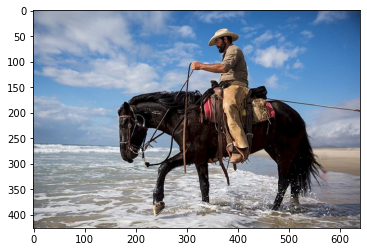

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0149, 0.8706, 0.5688, 0.9648, 0.6222],
          [0.0136, 0.3800, 0.3194, 0.4710, 0.3665],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0532, 0.2857, 0.3313, 0.8918, 0.7823],
          [0.0426, 0.7292, 0.7340, 0.8571, 0.9200],
          [0.0230, 0.7451, 0.8101, 0.8406, 0.9208],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

In [6]:
from utils.ssd_model import DataTransform
import cv2
import matplotlib.pyplot as plt

image_file_path = "./data/cowboy-757575_640.jpg"
# image_file_path = "./data/arashi.jpg"
img = cv2.imread(image_file_path)
height, width, channels = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123) # BGRの平均値
input_size = 300
transform = DataTransform(input_size, color_mean) # 前処理 DataAugmentation

phase = 'val'
img_transformed, boxes, labels = transform(img, phase, "", "") # アノテーションはない
img = torch.from_numpy(img_transformed[:,:,(2,1,0)]).permute(2,0,1)

net.eval()
x = img.unsqueeze(0) # ミニバッチ次元を追加
detection = net(x)

print(detection.shape)
print(detection)

In [19]:
torch.__version__

'1.10.2'

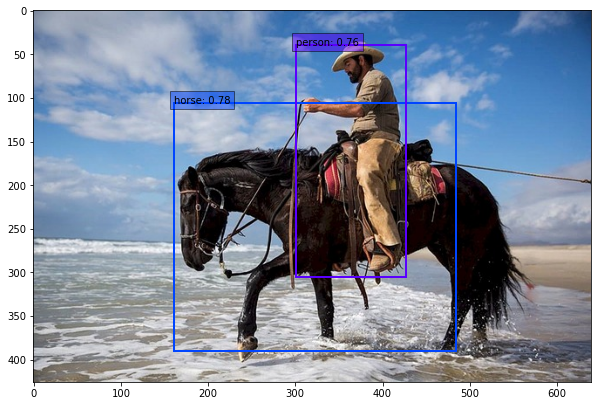

In [3]:
#　画像に対する予測
from utils.ssd_predict_show import SSDPredictShow

image_file_path = './data/cowboy-757575_640.jpg'

ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)

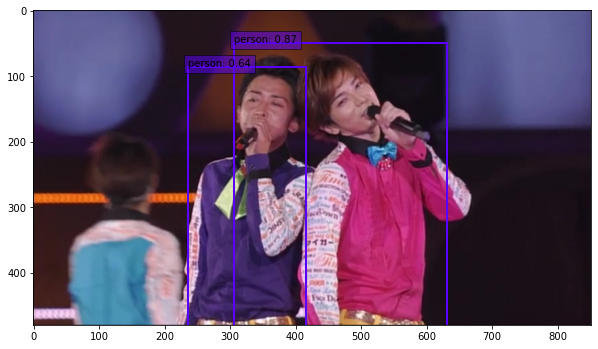

In [7]:
image_file_path = './data/arashi.jpg'

ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)